In [1]:
'''Code for fine-tuning Inception V3 for a new task.

Start with Inception V3 network, not including last fully connected layers.

Train a simple fully connected layer on top of these.


'''

import numpy as np
import keras
import random
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout
import inception_v3 as inception
import vgg16 as VGG
import prepare.collect as pc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

'''
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))
'''
N_CLASSES = 2
IMSIZE = (224, 224)

XML_DIR = "../data/annotations/xmls/"
IMG_DIR = "../data/images/"
VAL_RATIO = 0.3

# TO DO:: Replace these with paths to the downloaded data.
# Training directory
# train_dir = '../data/catdog/train'
# Testing directory
# test_dir = '../data/catdog/validation'


# Start with an Inception V3 model, not including the final softmax layer.
base_model = VGG.VGG16(weights='imagenet')
print ('Loaded vgg16 model')

Using TensorFlow backend.


K.image_dim_ordering: tf
Loaded vgg16 model


In [2]:
# Turn off training on base model layers
for layer in base_model.layers:
    layer.trainable = False
    

# Add on new fully connected layers for the output classes.
# x = Dense(1024, activation='relu')(base_model.get_layer('fc2').output)
# x = Dropout(0.5)(x)
# predictions = Dense(N_CLASSES, activation='softmax', name='predictions')(x)

base_model_last = base_model.get_layer('flatten').output
x = Dense(4096, activation='relu', name='fc1-1')(base_model_last)
x = Dense(4096, activation='relu', name='fc1-2')(x)
predictions = Dense(N_CLASSES, activation='softmax', name='predictions')(x)

# model = Model(input=base_model.input, output=predictions)
# for layer in model.layers:
#     layer.trainable = False

y = Dense(4096, activation='relu', name='fc2-1')(base_model_last)
y = Dense(4096, activation='linear', name='fc2-2')(y)
aux_predictions = Dense(4, activation='linear', name='aux_predictions')(y)

#model = Model(input=base_model.input, output=predictions)
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


model = Model(input=base_model.input, output=[predictions, aux_predictions])

#not training bbox part
model.get_layer("fc2-1").trainable=False
model.get_layer("fc2-2").trainable=False
model.get_layer("aux_predictions").trainable=False

#adam = optimizers.Adam(lr=0.00001)
sgd = optimizers.SGD(lr=0.001)
model.compile(optimizer=sgd,
              loss={'predictions': 'categorical_crossentropy', 'aux_predictions': 'mean_squared_error'},
             loss_weights={'predictions': 0.5, 'aux_predictions': 0}, metrics=['accuracy'])

# model = Model(input=base_model.input, output=aux_predictions)
# model.load_weights('catdog_combine.h5',by_name=True) 


#model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [3]:
# Show some debug output
print (model.summary())

# print ('Trainable weights')
#model.save_weights('catdog_pretrain.h5')
#print (model.trainable_weights)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [4]:
xmlFiles = pc.listAllFiles(XML_DIR)
infoList = list(map(lambda f:pc.getInfoTupleForXml(f,IMG_DIR) ,xmlFiles))

random.shuffle(infoList)
cutIndex = int(len(infoList)*VAL_RATIO)
train_files=infoList[:cutIndex]
val_files = infoList[cutIndex:]
train_files[50]

['../data/annotations/xmls/British_Shorthair_156.xml',
 '../data/images/British_Shorthair_156.jpg',
 0,
 (38.0, 13.213213213213212, 69.0, 58.85885885885885),
 (500, 333)]

In [5]:

#print(val_files)
np.random.seed()
img_datagen = ImageDataGenerator(rescale=1./255)

def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    return categorical

def my_load_img(img_path,img_datagen,size):
    img = image.load_img(img_path, target_size=size)
    x = image.img_to_array(img)

#     x = img_datagen.img_to_array(img)
    x = img_datagen.random_transform(x)
    x = img_datagen.standardize(x)
    #x = np.expand_dims(x, axis=0)
    return x
def my_img_generator(files,img_datagen,batch_size,bbox=False):
#     index_array = np.random.permutation(len(files))
    
    index = 0
    count = 0
    img_datas=[]
    img_labels=[]
    img_bboxes=[]
    while 1:
        # create numpy arrays of input data
        # and labels, from each line in the file
        if count < batch_size:
            img_datas.append(my_load_img(files[index][1],img_datagen,IMSIZE))
    #                 lable=[0.0,0.0]
    #                 lable[files[index][1]]=1.0
            img_labels.append(files[index][2])
            if bbox:
                img_bboxes.append(np.array(files[index][3]))
            index=(index+1)%len(files)
            count+=1
        else:
            count=0
            #print(img_datas)
            one_hot_labels=to_categorical(img_labels, num_classes=2)
            if bbox:
                yield (np.array(img_datas),[np.array(one_hot_labels),np.array(img_bboxes)])
                # yield (np.array(img_datas),np.array(img_bboxes))
            else:
                yield (np.array(img_datas),np.array(one_hot_labels))
            img_datas = []
            img_labels = []
            img_bboxes=[]
#             random.shuffle(files)
            

batch_size=32
# t = next(my_img_generator(train_files,img_datagen,batch_size))

# model.load_weights('catdog_pretrain_nf.h5') 
# train_data
# train_data.shape
my_train_generator = my_img_generator(train_files,img_datagen,batch_size,True)
my_val_generator = my_img_generator(val_files,img_datagen,batch_size,True)

#train_datagen = ImageDataGenerator(rescale=1./255)
# train_generator = train_datagen.flow_from_directory(
#         train_dir,  # this is the target directory
#         target_size=IMSIZE,  # all images will be resized to 299x299 Inception V3 input
#         batch_size=batch_size,
#         class_mode='categorical')

#test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#         test_dir,  # this is the target directory
#         target_size=IMSIZE,  # all images will be resized to 299x299 Inception V3 input
#         batch_size=batch_size,
#         class_mode='categorical')

#print(next(my_train_generator)[1])
# print(a[1].shape)
# print(a[1])

In [6]:
model.load_weights('catdog_combine_1.h5',by_name=True) 

In [7]:

# my_train_generator = my_img_generator(train_files,img_datagen,32)
# my_val_generator = my_img_generator(val_files,img_datagen,32)
# model.fit_generator(
#         my_train_generator,
#         samples_per_epoch=128,
#         nb_epoch=10,
#         validation_data=test_datagen,
#         verbose=2,
#         nb_val_samples=128)

model.fit_generator(
        my_train_generator,
        samples_per_epoch=128,
        nb_epoch=50,
        validation_data=my_val_generator,
        verbose=2,
        nb_val_samples=128)
model.save_weights('catdog_combine_1.h5')

Epoch 1/50
6s - loss: 0.1188 - predictions_loss: 0.2376 - aux_predictions_loss: 96.5082 - predictions_acc: 0.8672 - aux_predictions_acc: 0.8047 - val_loss: 0.1519 - val_predictions_loss: 0.3039 - val_aux_predictions_loss: 64.0934 - val_predictions_acc: 0.8438 - val_aux_predictions_acc: 0.8281
Epoch 2/50
3s - loss: 0.1000 - predictions_loss: 0.2000 - aux_predictions_loss: 62.6169 - predictions_acc: 0.9219 - aux_predictions_acc: 0.8516 - val_loss: 0.1466 - val_predictions_loss: 0.2932 - val_aux_predictions_loss: 96.8909 - val_predictions_acc: 0.8281 - val_aux_predictions_acc: 0.8203
Epoch 3/50
3s - loss: 0.1543 - predictions_loss: 0.3086 - aux_predictions_loss: 76.6213 - predictions_acc: 0.8438 - aux_predictions_acc: 0.8125 - val_loss: 0.1343 - val_predictions_loss: 0.2687 - val_aux_predictions_loss: 59.0221 - val_predictions_acc: 0.9062 - val_aux_predictions_acc: 0.8359
Epoch 4/50
3s - loss: 0.1504 - predictions_loss: 0.3007 - aux_predictions_loss: 78.7711 - predictions_acc: 0.8359 - au

[array([[ 0.00138626,  0.99861372]], dtype=float32), array([[ 15.269701  ,   9.14763927,  72.87234497,  61.56257629]], dtype=float32)]


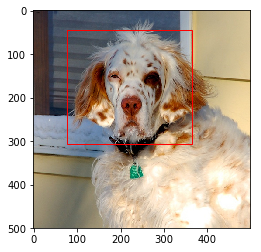

[array([[ 0.09114135,  0.90885866]], dtype=float32), array([[ 42.73282242,  24.17757797,  63.85802078,  61.74715424]], dtype=float32)]


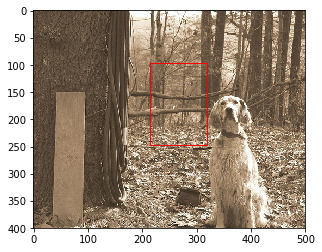

[array([[ 0.09657196,  0.90342808]], dtype=float32), array([[ 24.96319962,   4.39060068,  95.45166779,  83.46823883]], dtype=float32)]


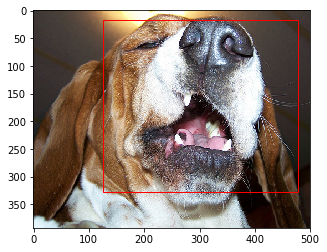

[array([[ 0.0164186 ,  0.98358142]], dtype=float32), array([[ 21.79852676,   5.91358423,  87.84641266,  87.12695312]], dtype=float32)]


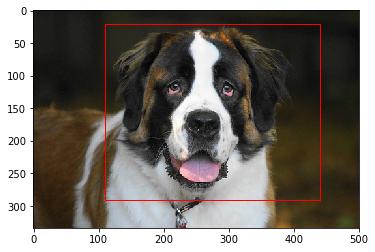

[array([[ 0.64715487,  0.35284513]], dtype=float32), array([[ 42.87636948,  36.41980362,  64.42156219,  62.08346558]], dtype=float32)]


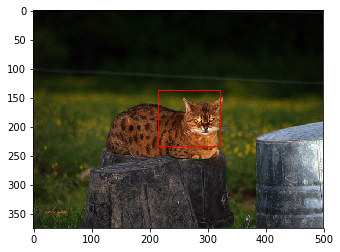

[array([[ 0.43262187,  0.5673781 ]], dtype=float32), array([[ 25.53476906,  24.73101425,  62.56150436,  58.20242691]], dtype=float32)]


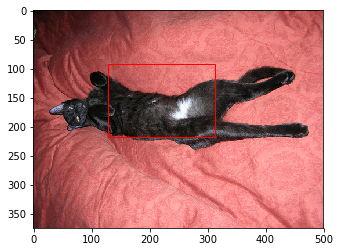

[array([[ 0.98763406,  0.01236592]], dtype=float32), array([[ 29.24162292,   0.22531214,  83.4197998 ,  50.38723373]], dtype=float32)]


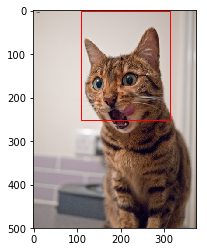

[array([[ 0.19437596,  0.80562395]], dtype=float32), array([[ 14.85180092,  12.91792679,  84.51942444,  60.94056702]], dtype=float32)]


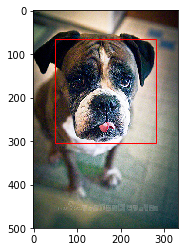

[array([[ 0.08269068,  0.91730928]], dtype=float32), array([[ 17.45445251,  18.1478672 ,  64.7113266 ,  76.34262848]], dtype=float32)]


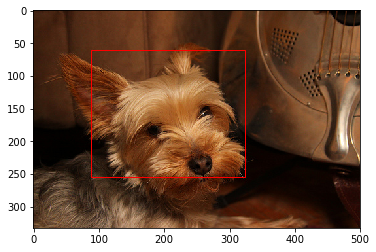

[array([[  8.79127765e-04,   9.99120891e-01]], dtype=float32), array([[ 25.28334618,  13.82884121,  65.70967865,  56.95874023]], dtype=float32)]


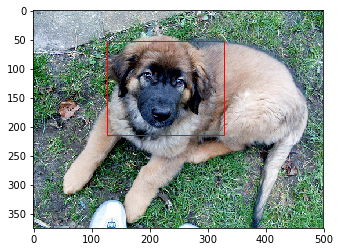

In [8]:

# img_path = '../data/cat2.jpg'
test_img = train_files[0]
img_path = test_img[1]
# img = image.load_img(img_path, target_size=IMSIZE)
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)

# x = inception.preprocess_input(x)
# x = my_load_img(img_path,img_datagen,IMSIZE)
# x = np.expand_dims(x, axis=0)
# preds = model.predict(x)[0]
# print('Predicted:', preds)
# width=test_img[4][0]
# height= test_img[4][1]
# actual_preds=[preds[0]*width*0.01,preds[1]*height*0.01,preds[2]*width*0.01,preds[3]*height*0.01]
# print('Actual_preds',actual_preds)

def getPredForImg(img_path):
    x = my_load_img(img_path,img_datagen,IMSIZE)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    return preds
def testImage(img_path,preds):  
    size = Image.open(img_path).size
    width=size[0]
    height=size[1]
    im = np.array(Image.open(img_path), dtype=np.uint8)
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)
    actual_preds=[preds[0]*width*0.01,preds[1]*height*0.01,preds[2]*width*0.01,preds[3]*height*0.01]
    # Create a Rectangle patch
    rect = patches.Rectangle((actual_preds[0],actual_preds[1]),actual_preds[2]-actual_preds[0],actual_preds[3]-actual_preds[1],linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()
    return
files = pc.listAllFiles("../data/test/")
random.shuffle(files)
for f in files[30:40]:
    preds = getPredForImg(f)
    print(preds)
    testImage(f,preds[1][0])
    
# preds = getPredForImg("../data/bill.jpg")
# testImage("../data/bill.jpg",preds)

In [9]:
Image.open(img_path).size

(500, 334)